In [1]:
import subprocess
# list GPUs
gpu_list = subprocess.check_output(["nvidia-smi", "-L"]).decode().strip().split("\n")
num_gpus = len(gpu_list)
gpu_models = [line.split()[1] for line in gpu_list] if gpu_list[0] else []
print(f"✅ Detected {num_gpus} GPU(s): {gpu_models}")

import xgboost as xgb
print("🔧 XGBoost version:", xgb.__version__)

✅ Detected 2 GPU(s): ['0:', '1:']
🔧 XGBoost version: 2.0.3


In [2]:
!pip install --quiet --upgrade xgboost pandas scikit-learn matplotlib seaborn optuna skl2onnx onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 6.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 88.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 85.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 87.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 71.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the 

In [3]:
!pip install optuna skl2onnx onnxruntime --quiet

In [4]:
import pandas as pd

# Load balanced data
path = "/kaggle/input/datasetos/linux_syslog_labeled.csv"
df = pd.read_csv(path)
print("▶️ Shape:", df.shape)
print("▶️ Label distribution:\n", df.label.value_counts())

df.head(3)

▶️ Shape: (50749, 16)
▶️ Label distribution:
 label
idle           14143
ram-heavy      10647
cpu-heavy      10221
mixed-heavy     5448
mixed           5189
io-heavy        5101
Name: count, dtype: int64


,timestamp,cpu_percent,memory_percent,load_avg_1,load_avg_5,load_avg_15,pid,name,cpu_process,memory_process,read_bytes,write_bytes,ctx_voluntary,ctx_involuntary,nice,label
0,1.747660e+09,0.6,40.0,0.0,0.0,0.0,2374,mpris-proxy,0.0,0.085696,0,0,416,23,0,idle
1,1.747660e+09,0.6,40.0,0.0,0.0,0.0,2375,pipewire,0.0,0.334251,81920,0,1740,459,-11,idle
2,1.747660e+09,0.6,40.0,0.0,0.0,0.0,2376,pipewire,0.0,0.125604,0,0,8,14,0,idle


In [5]:
from sklearn.preprocessing import LabelEncoder

# Drop non-numeric / unused columns
drop_cols = ['timestamp','pid','name']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Handle missing
print("▶️ Nulls per col:\n", df.isnull().sum())
df = df.fillna(0)

# Separate X / y
X = df.drop(columns=['label']).astype('float32')
y = df['label']

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("▶️ Classes:", le.classes_)

▶️ Nulls per col:
 cpu_percent        0
memory_percent     0
load_avg_1         0
load_avg_5         0
load_avg_15        0
cpu_process        0
memory_process     0
read_bytes         0
write_bytes        0
ctx_voluntary      0
ctx_involuntary    0
nice               0
label              0
dtype: int64
▶️ Classes: ['cpu-heavy' 'idle' 'io-heavy' 'mixed' 'mixed-heavy' 'ram-heavy']


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.2,
    stratify=y_enc,
    random_state=42
)
print("▶️ Train/Test sizes:", X_train.shape, X_test.shape)

▶️ Train/Test sizes: (40599, 12) (10150, 12)


In [7]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

In [8]:
params = {
    'objective': 'multi:softprob',
    'num_class': len(le.classes_),
    'tree_method': 'hist',         # dùng cùng với device='cuda'
    'device': 'cuda',
    'eval_metric': 'mlogloss',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}


# Multi-GPU support
if num_gpus > 1:
    params['n_gpus'] = num_gpus
    print(f"▶️ Enabled multi-GPU: n_gpus={num_gpus}")

▶️ Enabled multi-GPU: n_gpus=2


In [9]:
X_train.columns = [f"f{i}" for i in range(X_train.shape[1])]
X_test.columns = [f"f{i}" for i in range(X_test.shape[1])]


In [10]:
evals = [(dtrain, 'train'), (dtest, 'eval')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=10
)

[0]	train-mlogloss:1.50494	eval-mlogloss:1.50487


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:07:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_gpus" } are not used.

  msg += ".  Got " + str(got)


[10]	train-mlogloss:0.44738	eval-mlogloss:0.44767
[20]	train-mlogloss:0.15924	eval-mlogloss:0.15944
[30]	train-mlogloss:0.05881	eval-mlogloss:0.05893
[40]	train-mlogloss:0.02221	eval-mlogloss:0.02226
[50]	train-mlogloss:0.00854	eval-mlogloss:0.00856
[60]	train-mlogloss:0.00343	eval-mlogloss:0.00345
[70]	train-mlogloss:0.00148	eval-mlogloss:0.00149
[80]	train-mlogloss:0.00071	eval-mlogloss:0.00071
[90]	train-mlogloss:0.00039	eval-mlogloss:0.00040
[100]	train-mlogloss:0.00026	eval-mlogloss:0.00026
[110]	train-mlogloss:0.00019	eval-mlogloss:0.00019
[120]	train-mlogloss:0.00016	eval-mlogloss:0.00016
[130]	train-mlogloss:0.00014	eval-mlogloss:0.00014
[140]	train-mlogloss:0.00013	eval-mlogloss:0.00013
[150]	train-mlogloss:0.00012	eval-mlogloss:0.00013
[160]	train-mlogloss:0.00012	eval-mlogloss:0.00012
[170]	train-mlogloss:0.00011	eval-mlogloss:0.00012
[180]	train-mlogloss:0.00011	eval-mlogloss:0.00012
[190]	train-mlogloss:0.00011	eval-mlogloss:0.00012
[199]	train-mlogloss:0.00011	eval-mloglo

              precision    recall  f1-score   support

   cpu-heavy       1.00      1.00      1.00      2044
        idle       1.00      1.00      1.00      2829
    io-heavy       1.00      1.00      1.00      1020
       mixed       1.00      1.00      1.00      1038
 mixed-heavy       1.00      1.00      1.00      1090
   ram-heavy       1.00      1.00      1.00      2129

    accuracy                           1.00     10150
   macro avg       1.00      1.00      1.00     10150
weighted avg       1.00      1.00      1.00     10150



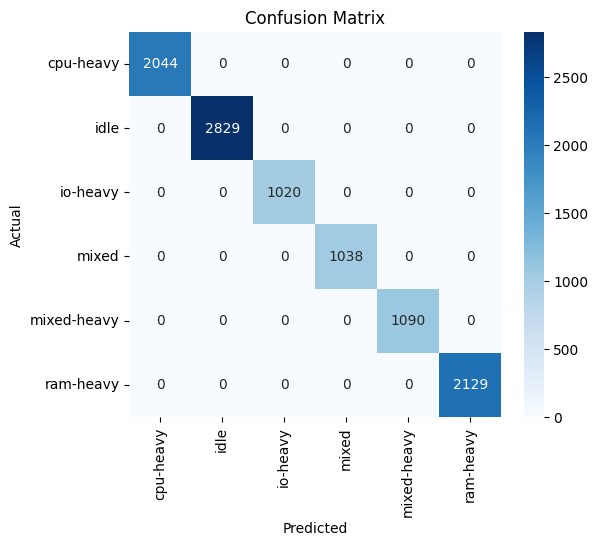

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred_prob = bst.predict(dtest)
y_pred_labels = y_pred_prob.argmax(axis=1)

# Report
print(classification_report(y_test, y_pred_labels, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix'); plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:10:52] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  msg += ".  Got " + str(got)


CV accuracy (5-fold): [0.89674877 0.95852217 0.948867   1.         0.83476205] mean = 0.9277799953112418


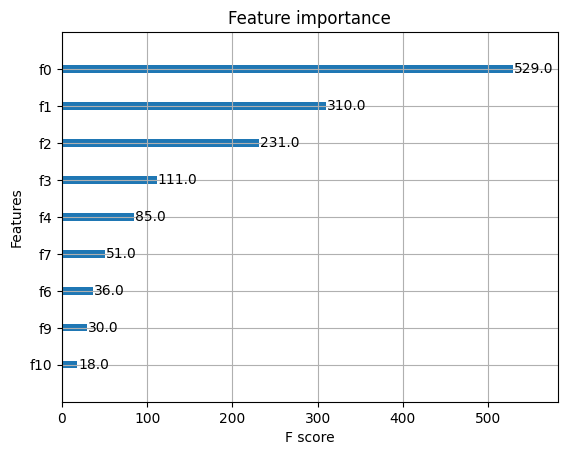

In [16]:
# 1. K-fold accuracy
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_final, X, y_enc, cv=5, scoring='accuracy')
print("CV accuracy (5-fold):", scores, "mean =", scores.mean())

# 2. Feature importance
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_final, max_num_features=10)
plt.show()


In [17]:
bst.save_model('xgb_os_scheduler_gpu.json')
import joblib
joblib.dump(le, 'label_encoder.pkl')
print("✅ Models saved: xgb_os_scheduler_gpu.json, label_encoder.pkl")

✅ Models saved: xgb_os_scheduler_gpu.json, label_encoder.pkl


In [18]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'tree_method': 'gpu_hist',
        'eval_metric': 'mlogloss',
        'objective': 'multi:softprob',
        'num_class': len(le.classes_),
        'seed': 42
    }
    model = XGBClassifier(**param)
    score = cross_val_score(model, X, y_enc, cv=3, scoring='accuracy')
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print("✅ Best Optuna params:", study.best_params)

[I 2025-06-05 14:11:04,689] A new study created in memory with name: no-name-638f7a52-54f2-4029-9986-fb96e8f2c6a0
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:11:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  msg += ".  Got " + str(got)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:11:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  msg += ".  Got " + str(got)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:11:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device`

✅ Best Optuna params: {'max_depth': 8, 'eta': 0.24705139641269935, 'subsample': 0.6210966691390368, 'colsample_bytree': 0.9127337445926161}


In [14]:
!pip install onnxmltools --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.0/329.0 kB 7.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 9.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
tensorflow-metadata 1.17.0 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.2 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-storage 2.19.0 requires google-api-core<3.0.0dev,>=2.15.0, but you have google-api

In [15]:
from xgboost import XGBClassifier
from onnxmltools.convert import convert_xgboost
from onnxmltools.convert.common.data_types import FloatTensorType

# Giả sử bạn đã có X_train và y_train
xgb_final = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    tree_method='hist',
    device='cuda',
    eval_metric='mlogloss',
    seed=42
)
xgb_final.fit(X_train, y_train)

# Chuyển đổi sang ONNX
initial_type = [('input', FloatTensorType([None, X_train.shape[1]]))]
onnx_model = convert_xgboost(xgb_final, initial_types=initial_type)

# Lưu ra file
with open("xgb_os_sched.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("✅ Saved ONNX model with onnxmltools")


✅ Saved ONNX model with onnxmltools


In [ ]:
import joblib
import zipfile

# 1. Lưu model XGBoost gốc (JSON)
bst.save_model("/kaggle/working/xgb_os_scheduler_gpu.json")

# 2. Lưu LabelEncoder
joblib.dump(le, "/kaggle/working/label_encoder.pkl")

# 3. Lưu ONNX (nếu chưa lưu)
with open("/kaggle/working/xgb_os_sched.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("✅ Saved files in /kaggle/working:")
print("   - xgb_os_scheduler_gpu.json")
print("   - label_encoder.pkl")
print("   - xgb_os_sched.onnx")

# 4. (Tùy chọn) Nén tất cả vào một file ZIP
with zipfile.ZipFile("/kaggle/working/model_bundle.zip", "w") as zf:
    for fname in ["xgb_os_scheduler_gpu.json", "label_encoder.pkl", "xgb_os_sched.onnx"]:
        zf.write(f"/kaggle/working/{fname}", arcname=fname)

print("✅ Packed model_bundle.zip")


In [ ]:
from IPython.display import FileLink

# Tạo link tải file ZIP
FileLink('/kaggle/working/model_bundle.zip')
